In [2]:
import os

import pandas as pd
import re

import numpy as np

import random

import Neuron_analysis as na

import plotly
import plotly.offline
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [2]:
results_dir= 'D:/Complete_points/'

In [3]:
files= os.listdir(results_dir)

## Plots all downsampled points into same space ##

In [4]:
axons=[os.path.join(results_dir,i) for i in files if '_axons.csv' in i]

In [5]:
data_pd=pd.read_csv(axons[0])
data_pd.loc[100:105]

IndexError: list index out of range

In [8]:
fig=go.Figure()

for count,names in enumerate(axons):
    data_pd=pd.read_csv(names)
    name= re.search('\D{2}[0-9]{3}', names)[0]
    
    data_pd['name']= [na.give_me_name(i) for i in data_pd['atlas_ID']]
    data_pd['ML']= [na.stereotaxis(i,ml=1) for i in data_pd['x']]
    data_pd['AP']= [na.stereotaxis(i,ml=0) for i in data_pd['z']]
    data_pd['DV']= [i*25/1000 for i in data_pd['y']]
    
    fig.add_trace(go.Scatter3d( 
        x=data_pd['ML'],
        y=data_pd['DV'],
        z=data_pd['AP'],
        
        mode='markers',
        name=name,
        marker=dict(
            size=1,
            color=count,
            opacity=0.5
        ),
        
        text=data_pd['name'],
        hovertemplate= '%{text}<br> ML: %{x} mm <br> AP: %{z} mm'
        
    ))

camera = dict(
        eye=dict(x=0, y=-1, z=0)
    )

    #Need to change the axis title depending on the direction and orientation of the origional image (ie, imaging started from cerebellum vs. imaging started from olfactorybulb)
fig.update_layout(scene_camera=camera, 
                      scene=dict(
                        xaxis_title='Medial-lateral',
                        yaxis_title='Dorsal-ventral',
                        zaxis_title='Anterior-posterior'))
plot(fig,filename=results_dir+'allprojection3d.html')

'D:/Complete_points/allprojection3d.html'

## Plots the individual original points with associated ID ##

In [77]:
ori_points=[os.path.join(results_dir,i) for i in files if 'oripoints' in i]
ori_points

['D:/Complete_points/GF243D_oripoints_withID.csv',
 'D:/Complete_points/GF243_oripoints_withID.csv']

In [79]:
axons=pd.read_csv(ori_points[1])
#axons['name']= [na.give_me_name(i) for i in axons['atlasID']]
dendrites=pd.read_csv(ori_points[0])
#dendrites['name']= [na.give_me_name(i) for i in dendrites['atlasID']]
mousename=na.find_mousename(ori_points[1])

In [81]:
axons

,x,y,z,atlasID
0,5275.74,2194.85,3899.45,886
1,5275.51,2195.14,3898.52,886
2,5275.29,2195.44,3897.59,886
3,5275.06,2195.74,3896.66,886
4,5274.84,2196.03,3895.73,886
...,...,...,...,...
60055,5177.00,2768.27,4775.83,847
60056,5613.60,2982.40,4725.00,847
60057,5613.50,2982.40,4724.01,847
60058,5613.39,2982.40,4723.01,847


In [138]:
def make_scatter(axons, dendrites, mousename):
        
    fig=go.Figure()
    fig.add_trace(go.Scatter3d( 
        x=axons[::3]['x'],
        y=axons[::3]['y'],
        z=axons[::3]['z'],
        mode='markers',
        name='Axons',
        marker=dict(
            size=1,
            color='blue',
            opacity=0.5
        ),
        #hovertext= axons[::3]['name'],
        hovertext= axons['atlasID'],
        hoverinfo='text'
    ))
    
    fig.add_trace(go.Scatter3d(
        x=dendrites['x'],
        y=dendrites['y'],
        z=dendrites['z'],
        mode='markers',
        name='Dendrites',
        marker=dict(
            size=2,
            color='red',
            opacity=0.5),
        #hovertext= dendrites['name'],
        hovertext=dendrites['atlasID'],
        hoverinfo='text'
    ))

#Here we want horizontal view with dorsal surface toward us
#first we set a xz view for coronal section this is done by setting x and z as 0 in eye
# then, for y we want the smaller values to point toward us (because in our original coronal images dorsal surface is pointed up)
    camera = dict(
            eye=dict(x=0, y=0, z=2.5))
    #Need to change the axis title depending on the direction and orientation of the origional image (ie, imaging started from cerebellum vs. imaging started from olfactorybulb)
    fig.update_layout(scene_camera=camera, 
                      scene=dict(
                        xaxis_title='Medial-lateral',
                        yaxis_title='Dorsal-ventral',
                        zaxis_title='Anterior-posterior'))
    #fig.write_image(f"D:/2PT electroporation time/{mousename}.svg")
    plot(fig,filename='D:/2PT electroporation time/'+ mousename+'/3Dplot.html')
    

In [139]:
make_scatter(axons,dendrites,mousename)

## analysis of viral project injection site! ##

In [6]:
data=pd.read_excel(r'D:\viral_injectionsite\results.xlsx',index_col=0)

In [7]:
data

,Data_name,Total_voxels,Centroid_location_1,Centroid_location_2,Centroid_location_3,Centroid_id,Voxel_id
0,AL207_647,6480,121,276,60,1070,"[{9: 23, 1038: 1543, 1047: 14, 1070: 3873, 111..."
1,AL208_647,1691,137,274,51,1111,"[{9: 182, 625: 138, 945: 4, 1111: 1137, 182305..."
2,AL209_647,4218,109,270,69,1070,"[{1038: 75, 1047: 11, 1070: 4132}]"
3,AL210_647,1855,122,287,52,1070,"[{1047: 10, 1070: 1134, 1111: 159, 312782558: ..."
4,AL211_647,1584,106,276,66,1070,"[{1047: 94, 1070: 1490}]"
5,AL213_647,2944,98,272,73,1070,"[{1047: 44, 1070: 2900}]"
6,AL214_647,3679,133,272,54,1111,"[{9: 183, 577: 6, 625: 387, 670: 5, 854: 1, 94..."
7,AL215_647,2543,102,279,67,1070,"[{1038: 532, 1047: 1022, 1070: 989}]"
8,AL254_561,4580,97,281,46,201,"[{201: 2937, 981: 1217, 1047: 426}]"
9,AL255_561,9959,76,284,61,201,"[{201: 6655, 806: 771, 873: 187, 981: 2043, 10..."


In [8]:
data['Genotype']= ['Sim1Cre', 'Sim1Cre', 'Sim1Cre', 'Tlx3Cre', 'Rbp4Cre', 'Tlx3Cre', 'Rbp4Cre', 'Rbp4Cre', 'Rasgrf2dCre', 'Rasgrf2dCre',
                   'Rasgrf2dCre', 'Rasgrf2dCre', 'Rbp4Cre', 'Rbp4Cre', 'Sim1Cre', 'Ntsr1Cre', 'Ntsr1Cre', 'Ntsr1Cre', 'Tlx3Cre', 'Rbp4Cre', 
                   'Tlx3Cre', 'Sim1Cre', 'Ntsr1Cre', 'Ntsr1Cre', 'Ntsr1Cre', 'Sim1Cre', 'Sim1Cre', 'Rbp4Cre', 'Rbp4Cre', 'Scnn1aCre',
                  'Scnn1aCre','Scnn1aCre','Scnn1aCre','Scnn1aCre','Scnn1aCre','Scnn1aCre','Scnn1aCre']

In [9]:
data

,Data_name,Total_voxels,Centroid_location_1,Centroid_location_2,Centroid_location_3,Centroid_id,Voxel_id,Genotype
0,AL207_647,6480,121,276,60,1070,"[{9: 23, 1038: 1543, 1047: 14, 1070: 3873, 111...",Sim1Cre
1,AL208_647,1691,137,274,51,1111,"[{9: 182, 625: 138, 945: 4, 1111: 1137, 182305...",Sim1Cre
2,AL209_647,4218,109,270,69,1070,"[{1038: 75, 1047: 11, 1070: 4132}]",Sim1Cre
3,AL210_647,1855,122,287,52,1070,"[{1047: 10, 1070: 1134, 1111: 159, 312782558: ...",Tlx3Cre
4,AL211_647,1584,106,276,66,1070,"[{1047: 94, 1070: 1490}]",Rbp4Cre
5,AL213_647,2944,98,272,73,1070,"[{1047: 44, 1070: 2900}]",Tlx3Cre
6,AL214_647,3679,133,272,54,1111,"[{9: 183, 577: 6, 625: 387, 670: 5, 854: 1, 94...",Rbp4Cre
7,AL215_647,2543,102,279,67,1070,"[{1038: 532, 1047: 1022, 1070: 989}]",Rbp4Cre
8,AL254_561,4580,97,281,46,201,"[{201: 2937, 981: 1217, 1047: 426}]",Rasgrf2dCre
9,AL255_561,9959,76,284,61,201,"[{201: 6655, 806: 771, 873: 187, 981: 2043, 10...",Rasgrf2dCre


In [6]:
Centroid_id_name= [na.give_me_name(i) for i in data.Centroid_id]
data['Centroid_id_name']=Centroid_id_name

In [7]:
diameter= np.cbrt((data['Total_voxels']*3/4)/np.pi)
# approximate the diameter of spread by assuming a spherical shape 
data['inj_diameter']= diameter*25
# multipley number of voxel by 25 um each

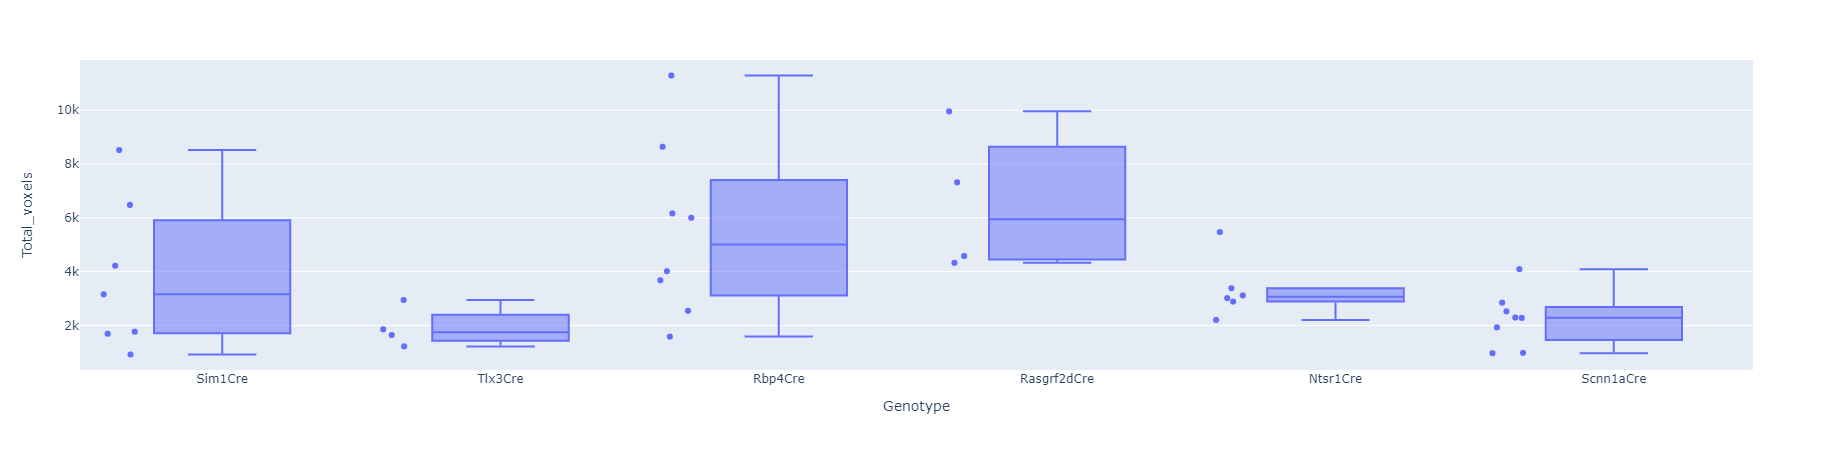

In [8]:
import plotly.express as px
fig = px.box(data, x="Genotype", y="Total_voxels", points="all")
fig.show()
fig.write_html("injection_voxels.html")

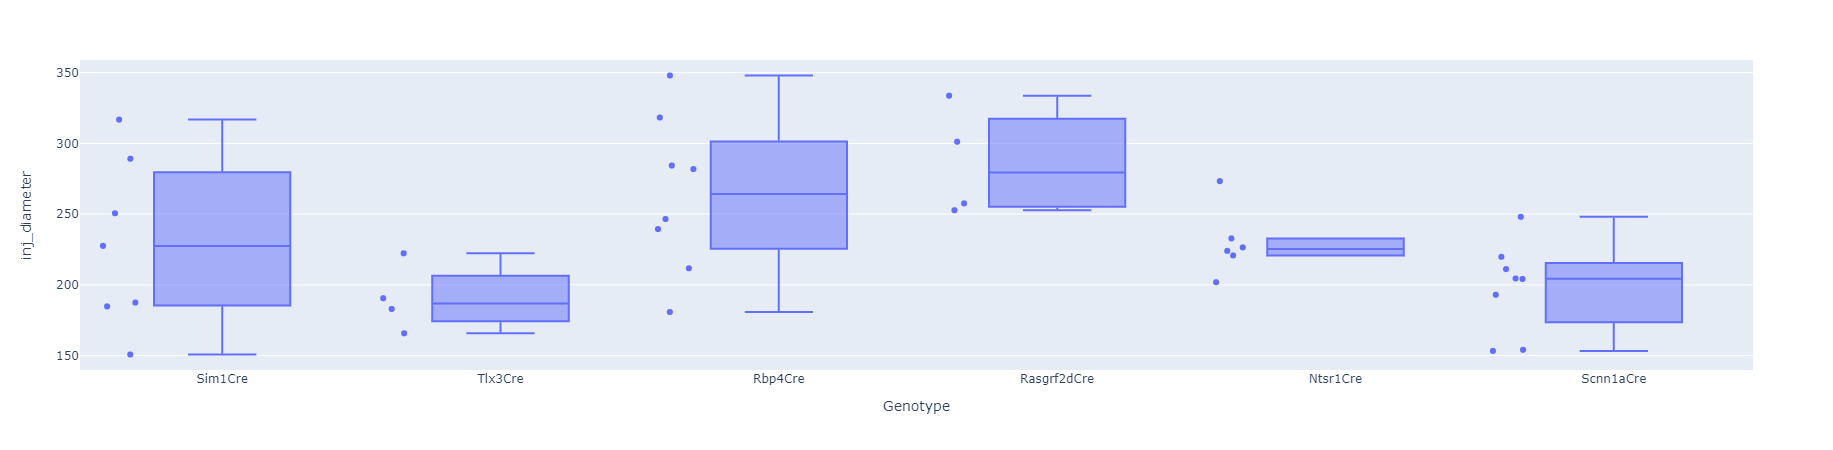

In [9]:
import plotly.express as px
fig = px.box(data, x="Genotype", y="inj_diameter", points="all")
fig.show()
fig.write_html("injection_diameter_um.html")

In [41]:
data=data.sort_values(by=['Genotype','Centroid_id'])
data = data.reset_index(drop=True)

In [42]:
data

,Data_name,Total_voxels,Centroid_location_1,Centroid_location_2,Centroid_location_3,Centroid_id,Voxel_id,Genotype
0,AL274_561,2205,77,284,106,862,"[{862: 1958, 1090: 247}]",Ntsr1Cre
1,AL284_647,3382,84,285,102,862,"[{862: 1824, 893: 232, 1038: 875, 1062: 48, 10...",Ntsr1Cre
2,AL274_647,5471,102,283,80,1038,"[{1038: 4515, 1062: 286, 1070: 587, 484682520:...",Ntsr1Cre
3,AL284_561,3014,114,284,75,1038,"[{1038: 1805, 1062: 526, 484682520: 683}]",Ntsr1Cre
4,AL285_647,2885,102,269,84,1038,"[{1038: 2492, 1070: 393}]",Ntsr1Cre
5,AL276_647,3114,106,314,73,484682520,"[{305: 2, 971: 889, 986: 13, 1038: 33, 1062: 1...",Ntsr1Cre
6,AL254_561,4580,97,281,46,201,"[{201: 2937, 981: 1217, 1047: 426}]",Rasgrf2dCre
7,AL255_561,9959,76,284,61,201,"[{201: 6655, 806: 771, 873: 187, 981: 2043, 10...",Rasgrf2dCre
8,AL256_561,7322,76,286,63,201,"[{201: 5013, 806: 926, 873: 92, 981: 513, 1035...",Rasgrf2dCre
9,AL257_561,4327,79,263,60,981,"[{201: 2459, 981: 1868}]",Rasgrf2dCre


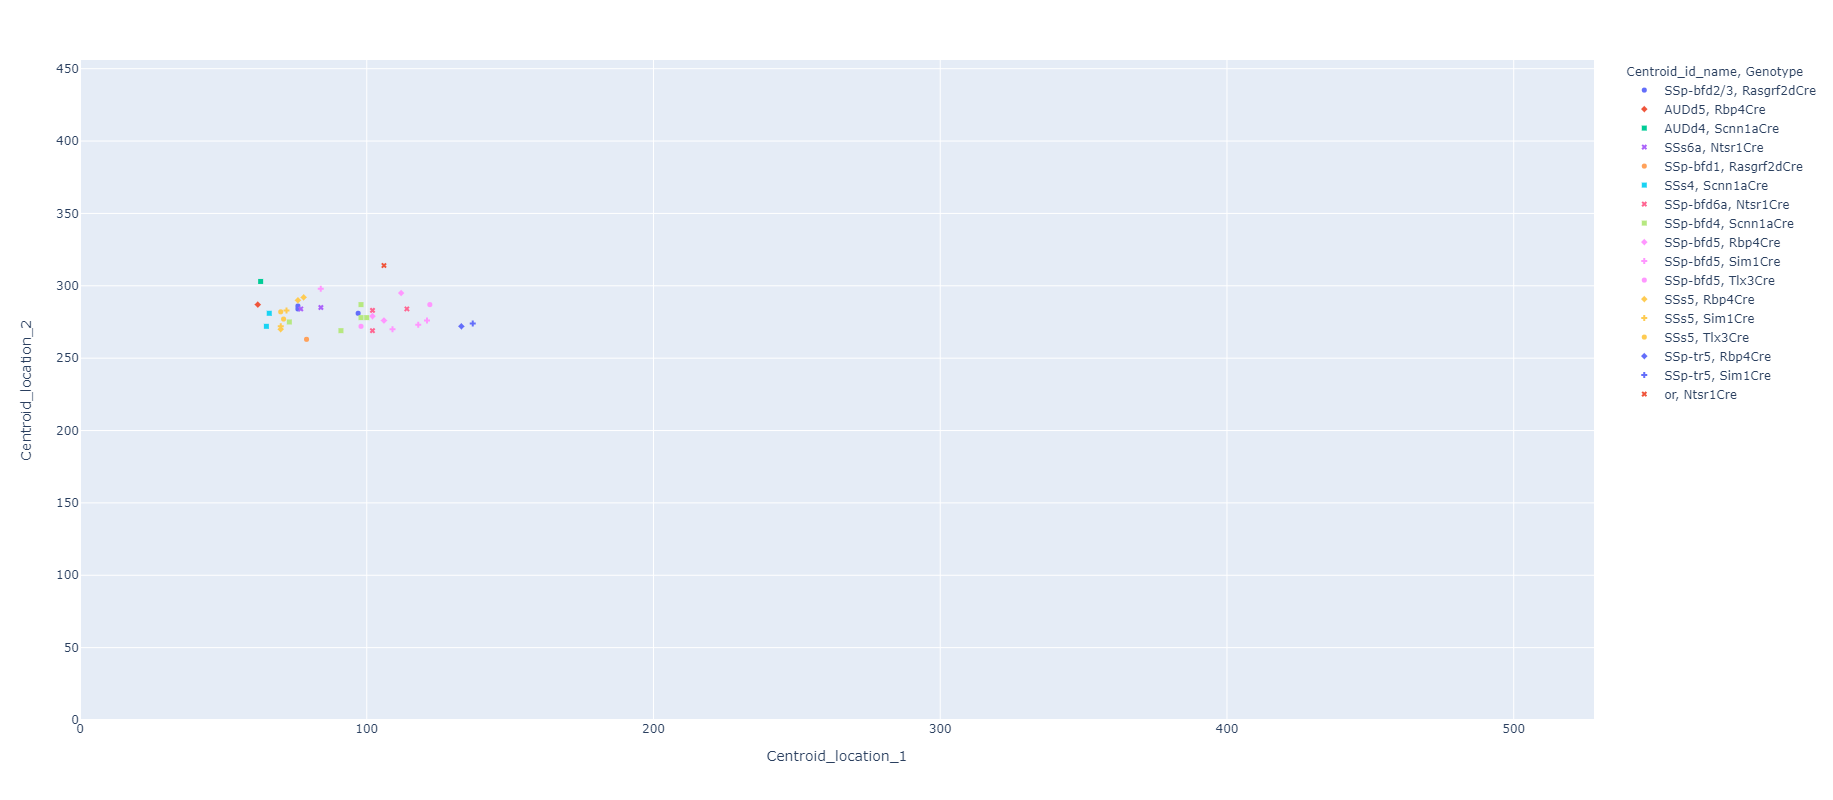

In [13]:
fig = px.scatter(data, x='Centroid_location_1', y='Centroid_location_2', color='Centroid_id_name', symbol='Genotype', 
                 width=800, height=800)
fig.update_traces(marker=dict(size=5))

fig.update_xaxes(range=[0, 528])
fig.update_yaxes(range=[0, 456])
#fig.update_yaxes(range=[0, 456], autorange="reversed")
# autorange reversed makes top left corner 0,0 but does not work with custom range...
fig.show()

fig.write_html("injection_centroid_horizontal.html")
# horizontal view but fliped (in an image, top is 0 but not bottom like in this graph)

In [4]:
# now plot the injection voxel's contribution of region ids


In [3]:
# now plot the injection voxel's contribution of region ids
import ast

def expand_df(datadf):
    data_expanded=pd.DataFrame(data={'sample_id': [],'region_id': [], 'region_name': [], 'count': [], 'percentage': []})

    for i in range(0,len(datadf)):

        data_specific=pd.DataFrame(data={'sample_id': [],'region_id': [], 'region_name': [], 'count': [], 'percentage': []})

        test=datadf['Voxel_id'][i]
        testdict=ast.literal_eval(test)[0]
        data_name=datadf['Data_name'][i]

        data_specific['sample_id']= [f'{data_name}']* len(testdict.keys())

        data_specific['region_id']= testdict.keys()
        id_name= [na.give_me_name(i) for i in testdict.keys()]
        data_specific['region_name']= id_name 

        counts=list(testdict.values())
        data_specific['count']= counts
        countsInt = np.array(counts)
        newArray = countsInt*100/sum(countsInt)
        data_specific['percentage']= newArray
        #convert to percentage

        data_expanded=data_expanded.append(data_specific)
    
    return data_expanded


In [37]:
# first separate into genotypes
genotypes=np.unique(data['Genotype'])

this_genotype=genotypes[0]
print(f'this genotype is {this_genotype}')

this_data= data[data['Genotype']== this_genotype]


this genotype is Ntsr1Cre


In [38]:
this_data=this_data.reset_index(drop=True)
this_df= expand_df(this_data)

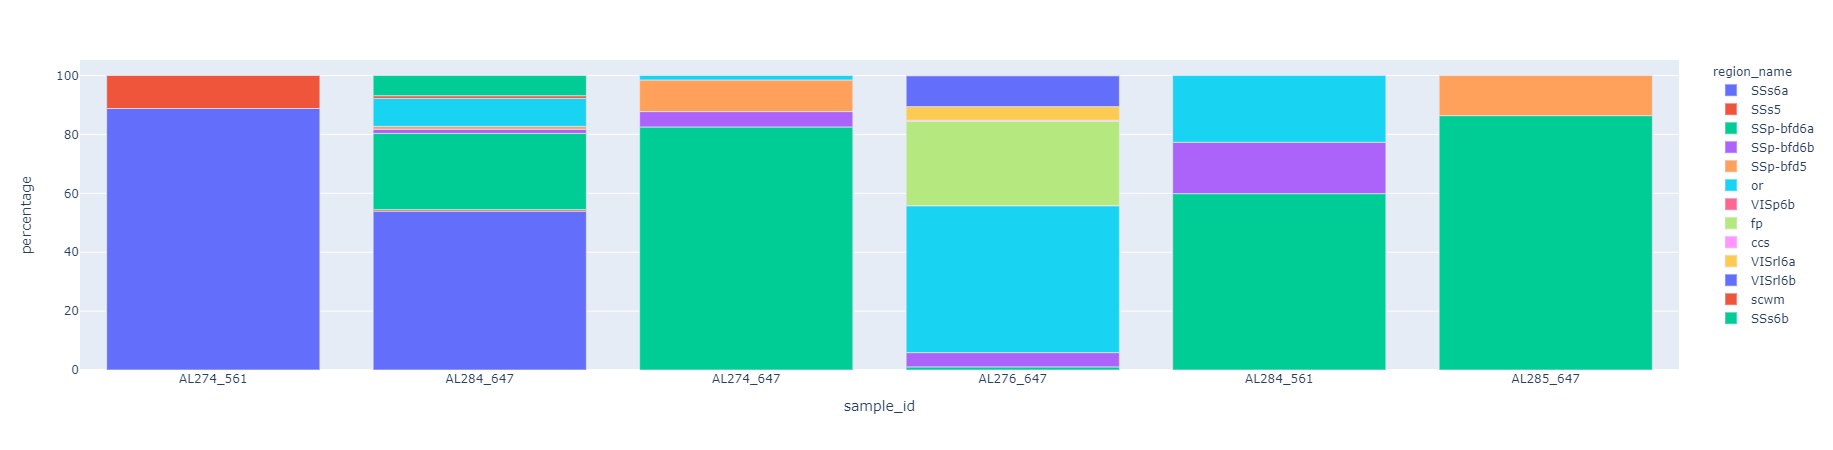

In [39]:
import plotly.express as px


fig = px.bar(this_df, x="sample_id", y="percentage", color="region_name")
fig.show()

fig.write_html(f"{this_genotype}_injectionvoxel_distribution.html")

this genotype is Ntsr1Cre


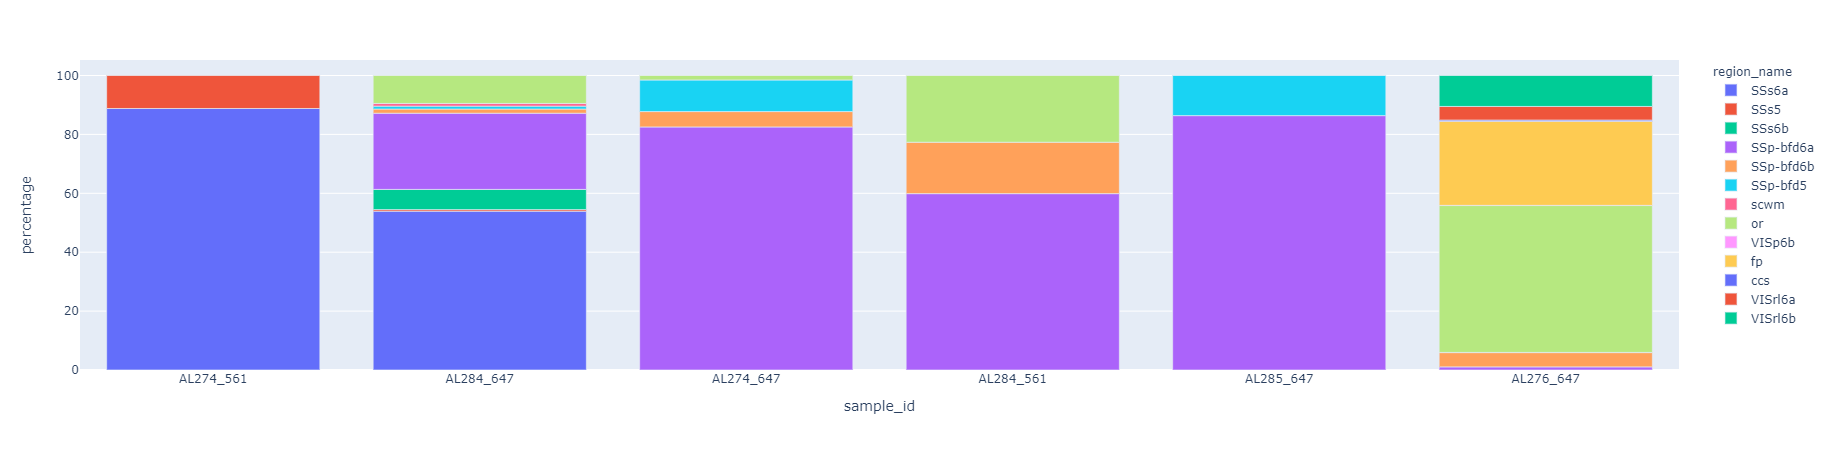

this genotype is Rasgrf2dCre


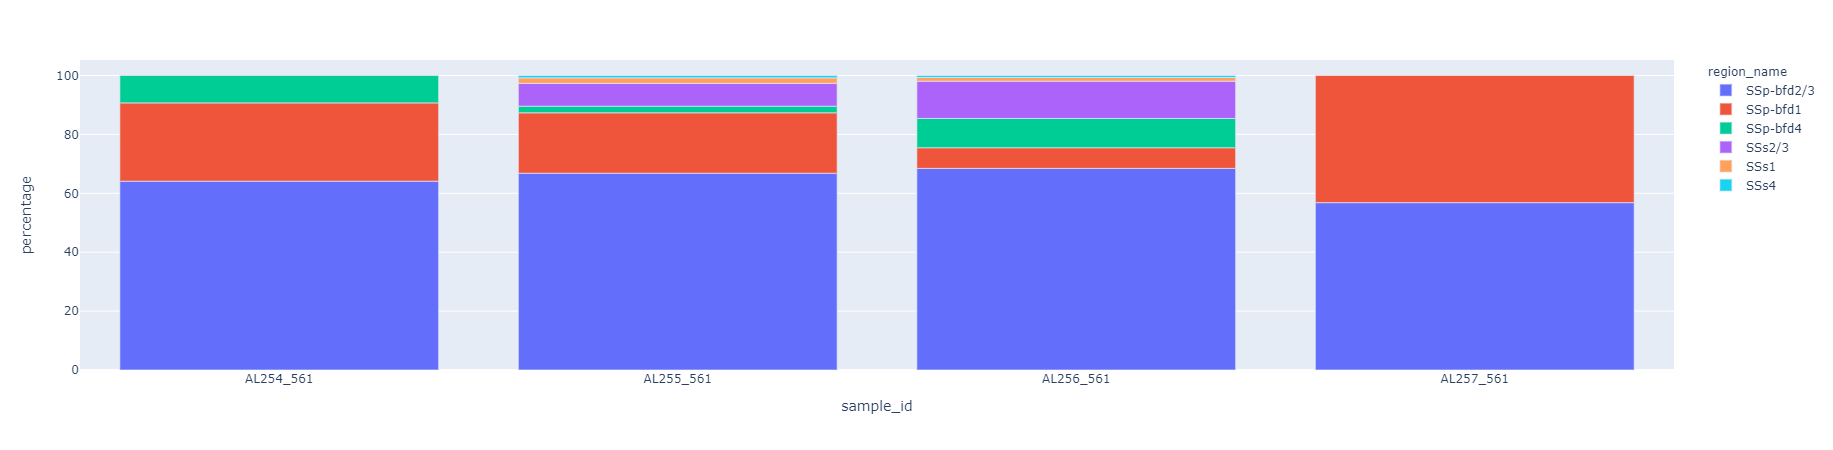

this genotype is Rbp4Cre


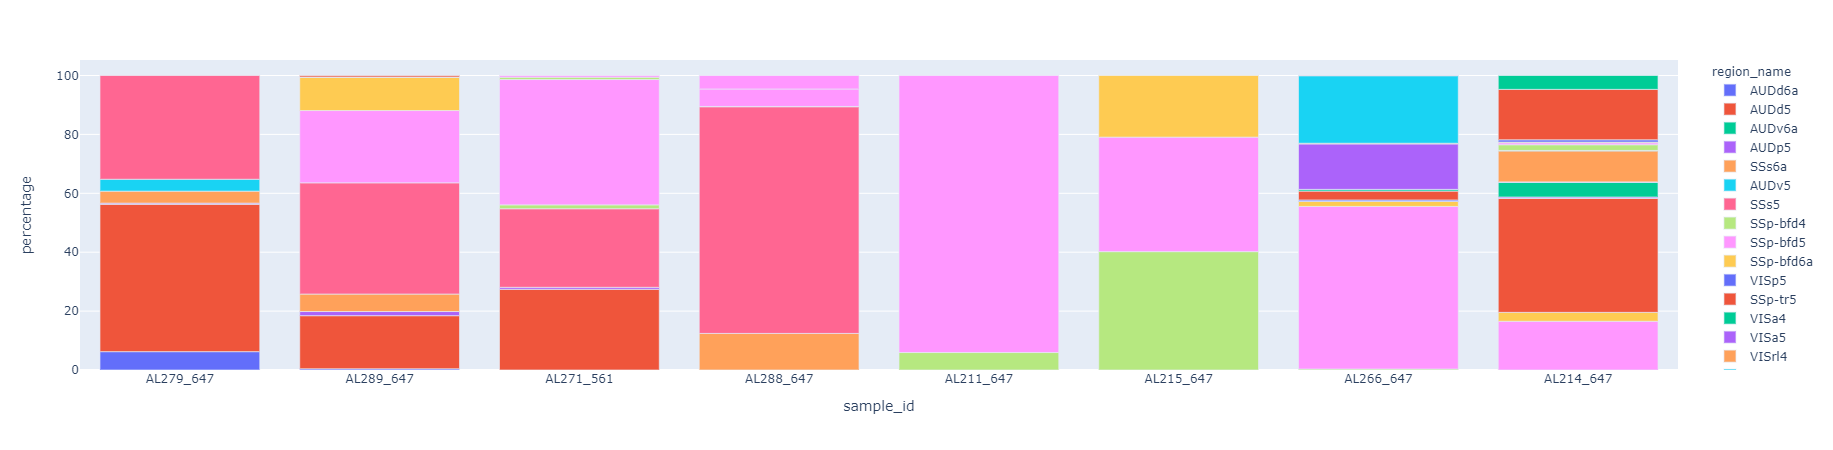

this genotype is Scnn1aCre


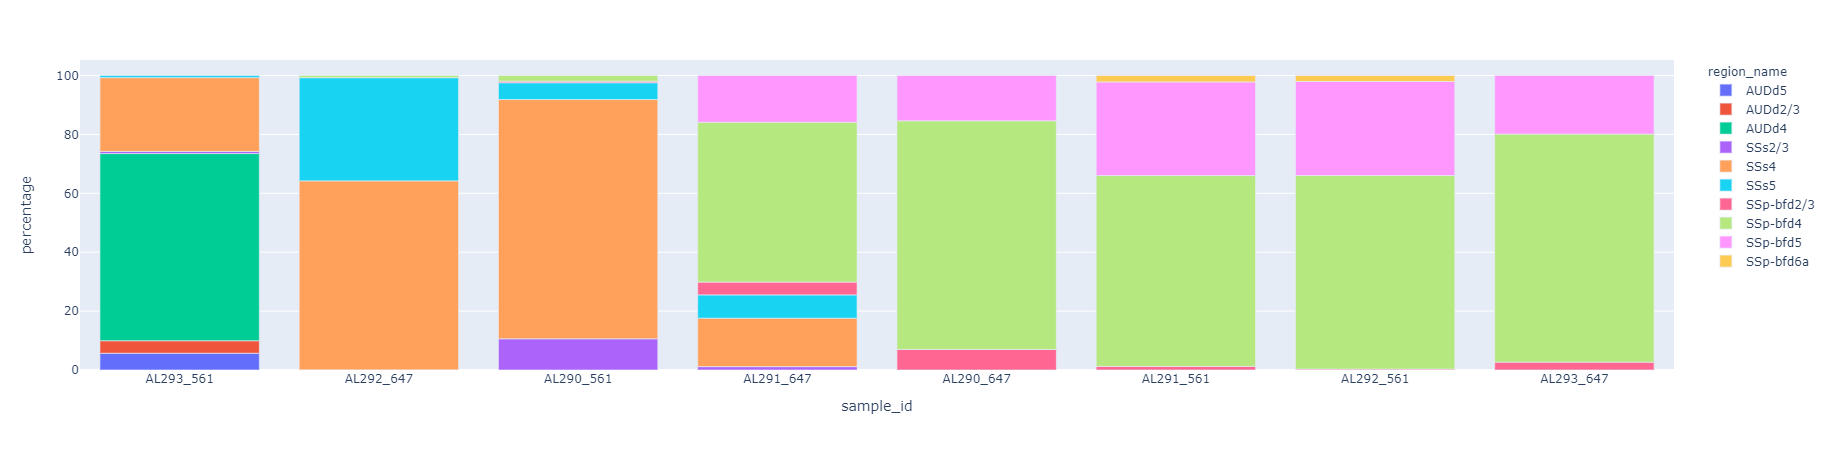

this genotype is Sim1Cre


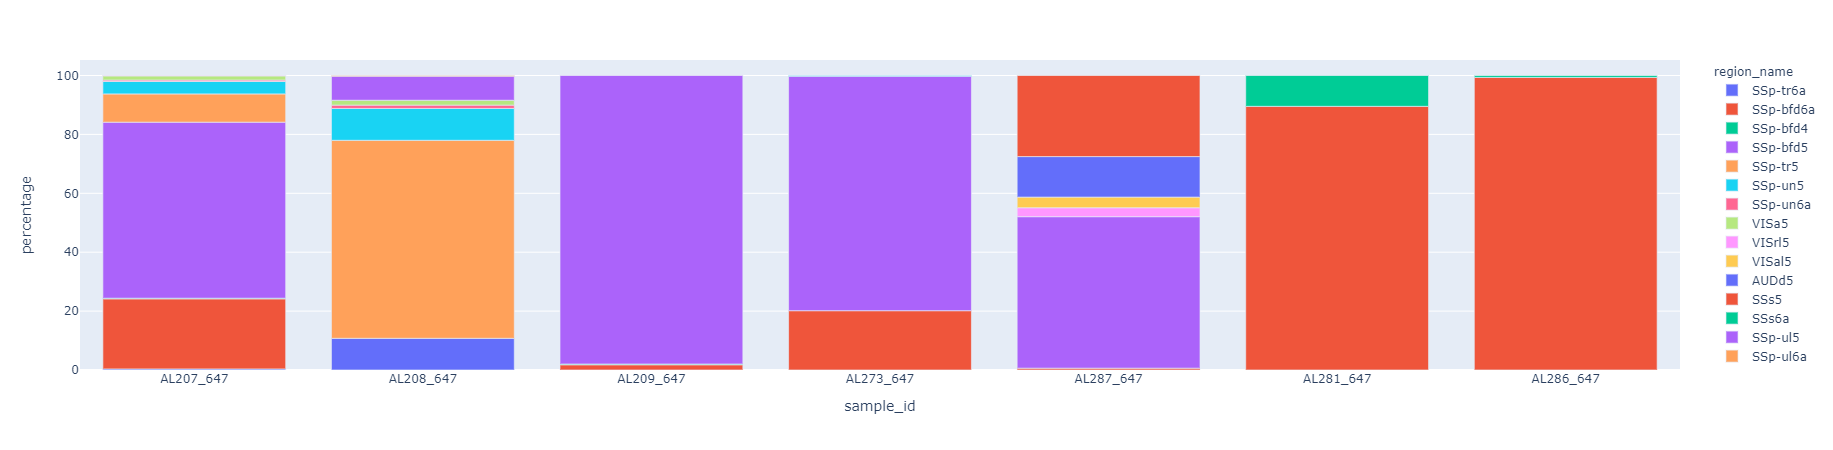

this genotype is Tlx3Cre


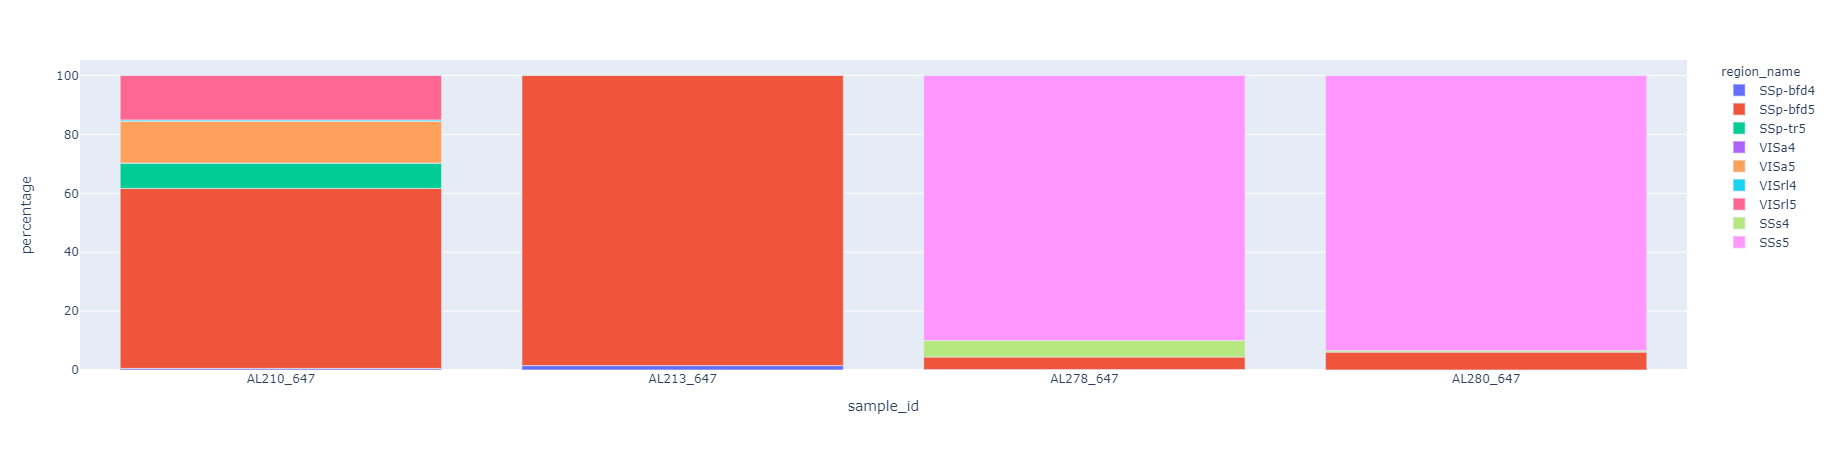

In [46]:
for i in genotypes:
    print(f'this genotype is {i}')

    this_data= data[data['Genotype']== i]
    
    this_data=this_data.reset_index(drop=True)
    this_df= expand_df(this_data)
    
    fig = px.bar(this_df, x="sample_id", y="percentage", color="region_name")
    fig.show()

    fig.write_html(f"{i}_injectionvoxel_distribution.html")